In [2]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [19]:
data_path = '/home/anuki/ICIP2022-ParEggChallenge/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
ann_file = '/home/anuki/ICIP2022-ParEggChallenge/5-fold/fold-2/val.json'
coco_gt = COCO(ann_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [33]:
folder = 'test-sliced'
pred_file = f'/home/anuki/ICIP2022-ParEggChallenge/predict/{folder}/result.json'
coco_dt = coco_gt.loadRes(pred_file)

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


In [21]:
imgIds = sorted(coco_gt.getImgIds())
cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [94]:
a = [key for key in cocoEval.ious if len(cocoEval.ious[key])>0 and len(cocoEval.ious[key][0])>1]
print(a)
print(cocoEval.ious[9283, 9])

[(1208, 0), (1209, 0), (9158, 9), (9208, 9), (9283, 9), (10857, 4)]
[[0.94455558 0.        ]]


In [91]:
np.max(cocoEval.ious[9283, 9], axis = 0)

array([0.94455558, 0.        ])

In [89]:
coco_gt.imgToAnns[9283]

[{'id': 9300,
  'image_id': 9283,
  'category_id': 9,
  'bbox': [1350.0, 2057.0, 191.00000000000003, 188.0],
  'area': 35908.00000000001,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0},
 {'id': 9301,
  'image_id': 9283,
  'category_id': 9,
  'bbox': [1518.9999999999998, 2288.0, 178.0, 191.0],
  'area': 33998.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0}]

In [90]:
coco_dt.imgToAnns[9283]

[{'image_id': 9283,
  'bbox': [1342.431396484375,
   2056.570114135742,
   200.29443359375,
   189.7993927001953],
  'score': 0.9705298542976379,
  'category_id': 9,
  'category_name': 'Taenia spp. egg',
  'segmentation': [],
  'iscrowd': 0,
  'area': 38015.76185732335,
  'id': 2456}]

In [46]:
coco_gt.imgs[1208]

{'id': 1208,
 'file_name': 'Ascaris lumbricoides_0208.jpg',
 'height': 4032,
 'width': 2117,
 'license': 1,
 'coco_url': None}

In [104]:
import json

def adjust_bbox(ann_path):
    file = open(ann_path)
    annotations = json.load(file)
    for ann in annotations['annotations']:
        for i in range(4):
            if ann['bbox'][i] < 0:
                ann['bbox'][i] = 0.0
    temp_file = 'mod-val.json'
    with open(temp_file, 'w') as file:
        json.dump(annotations, file)
    return temp_file
    

In [105]:
import numpy as np

def evaluate(data_path, ann_path, res_path):
    coco_gt = COCO(adjust_bbox(ann_path))
    coco_dt = coco_gt.loadRes(res_path)

    imgIds = sorted(coco_gt.getImgIds())
    cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')
    cocoEval.params.imgIds  = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    
    class_ious = [0] * 11
    class_avg_ious = []
    for i in range(11):
        ious = []
        for key, value in cocoEval.ious.items(): 
            if key[1] == i and len(value) > 0:
                ious.extend(np.max(value, axis=0))
        class_ious[i] = ious
        class_avg_ious.append(np.mean(ious))
        print(f"Average IoU of {coco_gt.cats[i]['name']}\t= {class_avg_ious[-1]}")

    print("mIoU =", np.mean(class_avg_ious))

    return cocoEval, class_ious, class_avg_ious, coco_gt, coco_dt

In [108]:
data_path = '/home/anuki/ICIP2022-ParEggChallenge/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
ann_path = '/home/anuki/ICIP2022-ParEggChallenge/5-fold/fold-1/val.json'
folder = 'test-sliced6'
res_path = f'/home/anuki/ICIP2022-ParEggChallenge/predict/{folder}/result.json'

cocoEval, class_ious, class_avg_ious, coco_gt, coco_dt = evaluate(data_path, ann_path, res_path)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.906
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   2.,   1.,   2.,   0.,   2.,   2.,   3.,  15.,  17.,
         31.,  62.,  91., 187., 419., 810., 558.]),
 array([0.        , 0.02493911, 0.04987822, 0.07481732, 0.09975643,
        0.12469554, 0.14963465, 0.17457375, 0.19951286, 0.22445197,
        0.24939108, 0.27433019, 0.29926929, 0.3242084 , 0.34914751,
        0.37408662, 0.39902572, 0.42396483, 0.44890394, 0.47384305,
        0.49878216, 0.52372126, 0.54866037, 0.57359948, 0.59853859,
        0.6234777 , 0.6484168 , 0.67335591, 0.69829502, 0.72323413,
        0.74817323, 0.77311234, 0.79805145, 0.82299056, 0.84792967,
        0.87286877, 0.89780788, 0.92274699, 0.9476861 , 0.9726252 ,
        0.99756431]),
 <BarContainer object of 40 artists>)

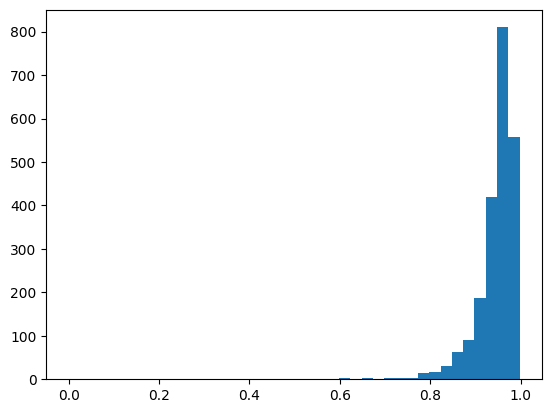

In [109]:
import matplotlib.pyplot as plt
total = sum(class_ious, start=[])
plt.hist(total, bins=40)

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img_id, coco_gt, coco_dt):

    image = plt.imread(data_path + '/' + coco_gt.imgs[img_id]['file_name'])
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid('off')

    for pred in coco_gt.imgToAnns[img_id]:
        x, y, w, h = pred['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for pred in coco_dt.imgToAnns[img_id]:
        x, y, w, h = pred['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

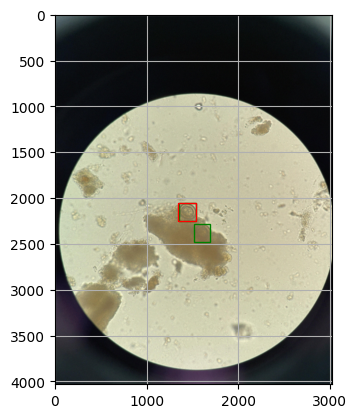

In [92]:
visualize(9283, coco_gt, coco_dt)

In [62]:
coco_dt.imgToAnns[1209]

[{'image_id': 1209,
  'bbox': [1330.1502685546875,
   706.25732421875,
   354.6839599609375,
   329.76983642578125],
  'score': 0.9431892037391663,
  'category_id': 0,
  'category_name': 'Ascaris lumbricoides',
  'segmentation': [],
  'iscrowd': 0,
  'area': 116964.0714591667,
  'id': 307},
 {'image_id': 1209,
  'bbox': [1538.67236328125, 0.0, 300.93798828125, 173.47964477539062],
  'score': 0.8812294006347656,
  'category_id': 0,
  'category_name': 'Ascaris lumbricoides',
  'segmentation': [],
  'iscrowd': 0,
  'area': 52206.61530645192,
  'id': 308},
 {'image_id': 1209,
  'bbox': [1213.9686279296875,
   170.2615966796875,
   66.0313720703125,
   133.9027099609375],
  'score': 0.42282184958457947,
  'category_id': 1,
  'category_name': 'Capillaria philippinensis',
  'segmentation': [],
  'iscrowd': 0,
  'area': 8841.779662653804,
  'id': 309},
 {'image_id': 1209,
  'bbox': [1757.1528930664062,
   1862.7424011230469,
   1021.1996459960938,
   517.7306213378906],
  'score': 0.4152384102

In [66]:
coco_gt.imgToAnns[1209]

[{'id': 1213,
  'image_id': 1209,
  'category_id': 0,
  'bbox': [1546.0, -104.0, 295.0, 269.0],
  'area': 79355.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0},
 {'id': 1214,
  'image_id': 1209,
  'category_id': 0,
  'bbox': [1341.0, 708.0, 333.0, 329.0],
  'area': 109557.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0}]

In [100]:
adjust_bbox(ann_path)

loading annotations into memory...


TypeError: expected str, bytes or os.PathLike object, not dict